# Requirements Setup

In [1]:
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# notebook preset
pd.set_option('display.max_columns', None)

# Data Import

In [2]:
df=pd.read_csv('/content/drive/MyDrive/netflix1.csv')
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [3]:
# data dimensions
print(f'Churn data has {df.shape[0]} rows and {df.shape[1]} columns.')

Churn data has 8790 rows and 10 columns.


In [4]:
# columns of the datas
df.columns

Index(['show_id', 'type', 'title', 'director', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in'],
      dtype='object')

# Fundamental Data Cleaning

In [5]:
# Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB


In [6]:
# checking for missing values

df.isnull().sum()

,0
show_id,0
type,0
title,0
director,0
country,0
date_added,0
release_year,0
rating,0
duration,0
listed_in,0


In [7]:
# checking for duplicate rows
df.duplicated().sum()

np.int64(0)

In [8]:
# Convert 'date_added' to datetime format
df['date_added'] = pd.to_datetime(df['date_added'])

# Check the change
df['date_added'].head()

,date_added
0,2021-09-25
1,2021-09-24
2,2021-09-24
3,2021-09-22
4,2021-09-24


In [9]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['day_added'] = df['date_added'].dt.day


# EDA (Exploratory Data Analysis)

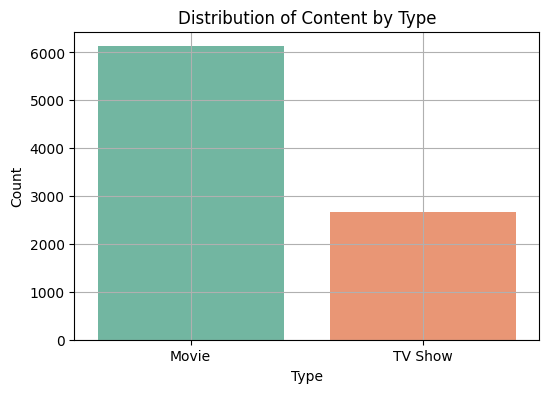

In [10]:
# Content Type Distribution (Movies vs TV Shows)

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='type', palette='Set2')
plt.title('Distribution of Content by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 🔍 Key Takeaways:
Movies dominate Netflix with over 6100 titles, compared to ~2700 TV Shows

Roughly 70% of Netflix’s content is Movie-based

Suggests Netflix prioritizes single-sitting content or that they’ve acquired more movie rights than TV

# 💡 Business Interpretation:
Netflix leans heavily on movie content, which could be a strategic move to attract viewers who prefer quick, standalone entertainment experiences. However, growing competition from platforms known for series (like Prime, Disney+) could pressure them to expand long-form content.

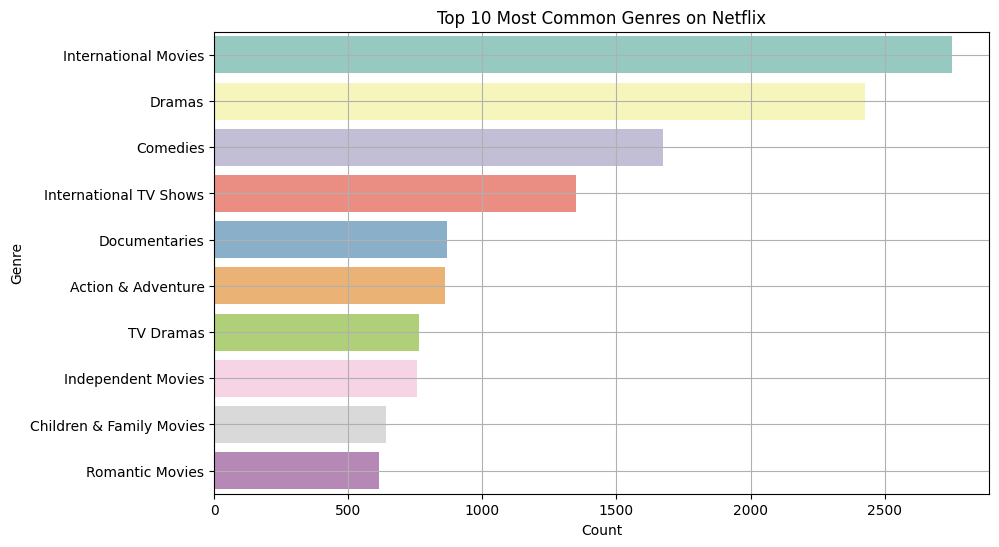

In [11]:
# Top 10 Genres (from listed_in) We’ll split the comma-separated genres and count:

# Split genre column
df['genres'] = df['listed_in'].apply(lambda x: [genre.strip() for genre in x.split(',')])

# Flatten genre list
all_genres = sum(df['genres'], [])

# Get top 10
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Set3')
plt.title('Top 10 Most Common Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

# 🔍 Key Takeaways:
Top 3 Genres:

1.International Movies

2.Dramas

3.Comedies

####Other highly ranked genres include:

* Documentaries

* TV Dramas

* Action & Adventure

The presence of "International" genres (Movies/TV) shows Netflix's strong focus on global audiences.

# 💡 Business Interpretation:
Netflix is clearly optimizing for global reach with international titles. The popularity of Dramas and Comedies aligns with universal viewer preferences. Heavy investment in Documentaries and Indie Films suggests they're targeting niche, quality-focused viewers alongside mass-market content.

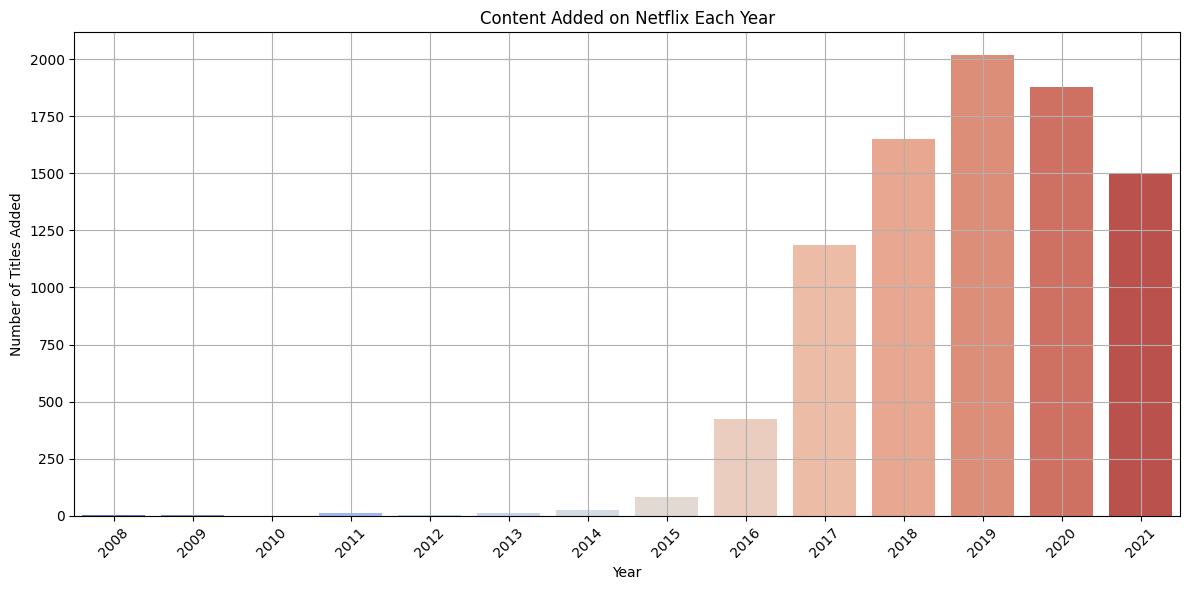

In [12]:
# Monthly & Yearly Content Trends

# A. Content Added Per Year

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='year_added', palette='coolwarm')
plt.title('Content Added on Netflix Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Titles Added')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

###📈 1. Content Added Each Year
####📊 Insight: Netflix’s library exploded between 2016 and 2019.

####🔍 Key Points:
* Minimal content was added before 2015.

* Rapid growth starts in 2016, peaks in 2019 with ~2,000 additions.

* Small dip post-2020 (likely due to the COVID-19 pandemic).

###💡 Business Insight:
Netflix saw aggressive expansion between 2016–2019, possibly due to global market launches and original content push. The decline in 2021 may be due to production halts during COVID.

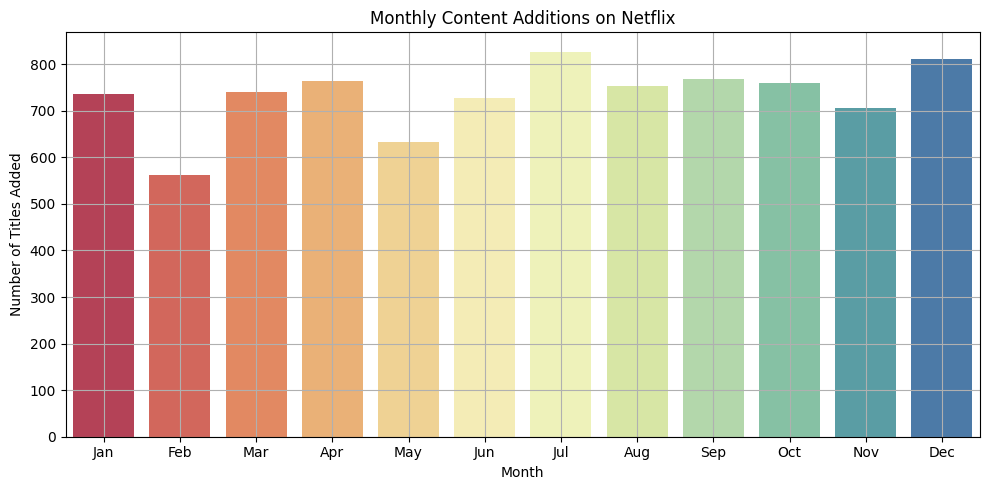

In [13]:
 # B. Monthly Releases (All-Time)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='month_added', order=range(1, 13), palette='Spectral')
plt.title('Monthly Content Additions on Netflix')
plt.xlabel('Month')
plt.ylabel('Number of Titles Added')
plt.xticks(ticks=range(12), labels=month_names)
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. Monthly Content Additions
####📊 Insight: Content is released consistently year-round, but some months stand out.

###🔍 Key Points:
* December has the highest releases — possibly driven by holiday engagement.

* February sees the lowest, potentially a post-awards season or slow quarter effect.

* Content drops are well-distributed, showing no seasonal dependency.

#💡 Business Insight:
Netflix keeps a steady stream of releases to keep subscriptions sticky. The holiday spike suggests targeting family viewership during peak season.

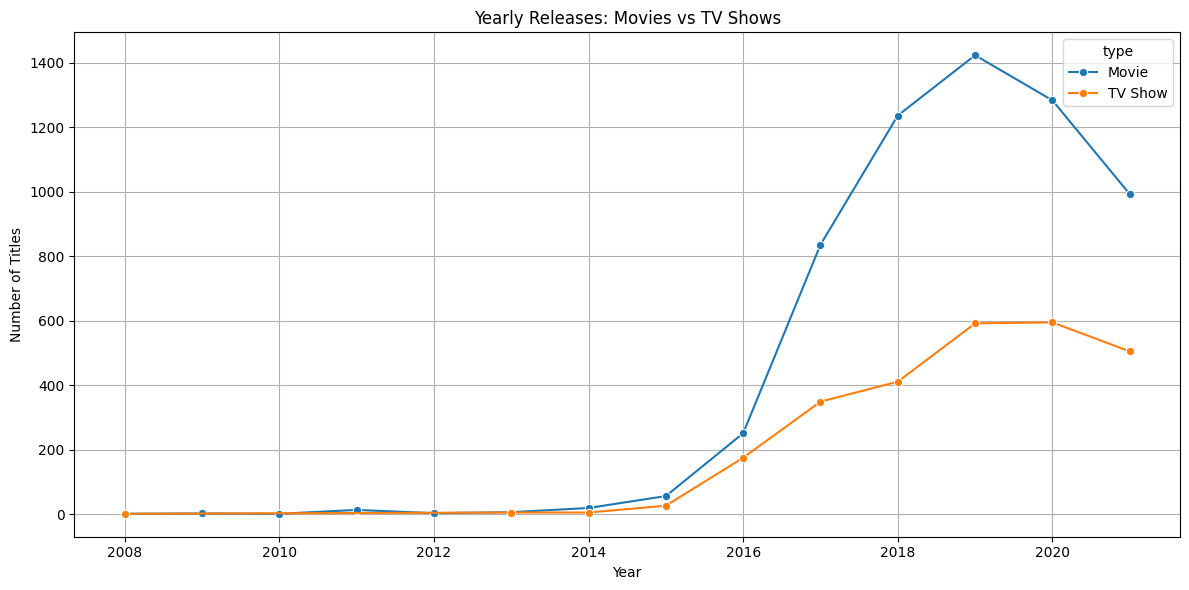

In [14]:
# C. Yearly Trends: Movies vs TV Shows

# Count releases by year and type
yearly_type = df.groupby(['year_added', 'type']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_type, x='year_added', y='count', hue='type', marker='o')
plt.title('Yearly Releases: Movies vs TV Shows')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.grid(True)
plt.tight_layout()
plt.show()

##🎞 3. Yearly Trends by Type (Movies vs. TV Shows)
####📊 Insight: Movies dominate Netflix’s growth curve.

###🔍 Key Points:
* Movies skyrocketed after 2016, peaking in 2019 with 1400+ titles.

* TV Shows grew steadily, but never outpaced movies.

* Post-2020, both categories declined slightly, more so for movies.

###💡 Business Insight:
Netflix has invested heavily in movies, possibly because they are quicker to produce and attract casual viewers. Still, TV Shows offer better retention — so the slower, steady growth might reflect long-term content strategy.

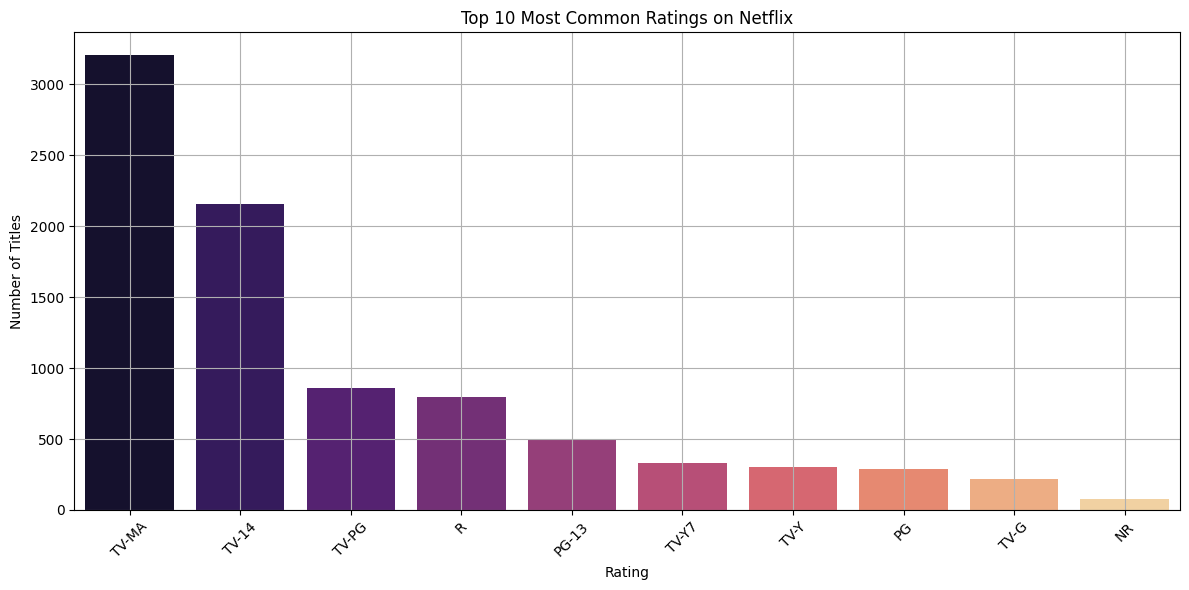

In [15]:
#🔢 Rating & Country Insights
# This gives depth to viewer targeting, parental controls, regional preferences, and marketing strategies.

# ✅ STEP 1: Rating Distribution (e.g. TV-MA, PG-13, etc.)

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='rating', order=df['rating'].value_counts().index[:10], palette='magma')
plt.title('Top 10 Most Common Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


##🔢 1. Rating Distribution
###📊 Insight: Mature audience dominates Netflix's catalog.

####🔍 Top Ratings:
* TV-MA (Mature Audiences) – ~3200+ titles

* TV-14 – ~2100+ titles

* TV-PG, R, PG-13 — significantly lower

###💡 Business Insight:
Netflix content heavily caters to teens and adults, particularly mature audiences (TV-MA). This reflects a focus on genres like thrillers, crime, and drama — aligning with binge-watch behavior and global viewership trends. Family or child-friendly content is relatively underrepresented.

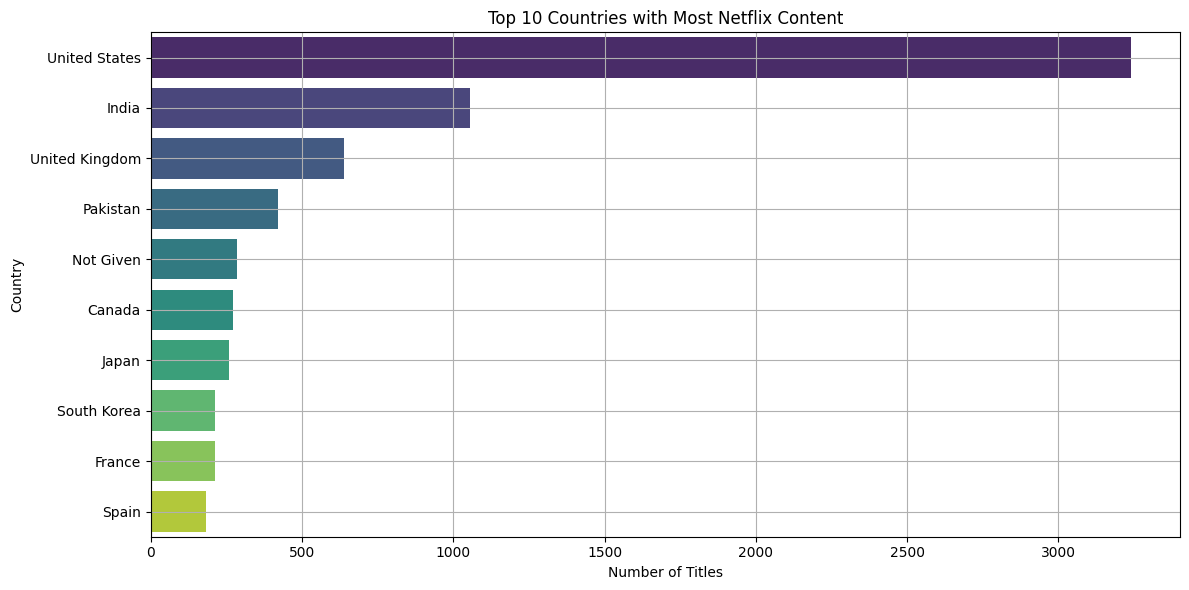

In [16]:
# ✅ Top 10 Countries with Most Content

plt.figure(figsize=(12, 6))
top_countries = df['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 10 Countries with Most Netflix Content')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.grid(True)
plt.tight_layout()
plt.show()

###🌍 2. Top 10 Countries by Content Volume
####📊 Insight: Netflix is a US-heavy platform, but India is its next biggest contributor.

###🔍 Highlights:
* USA: ~3200+ titles — the lion’s share

* India: ~1000+ titles — huge second lead

* UK, Pakistan, Canada, Japan follow

"Not Given" appears — we'll handle that in cleaning later.

###💡 Business Insight:
Netflix’s content is heavily US-centric, but the growth in Indian and UK content signals a global expansion strategy. This matches their real-world moves: heavy investments in Bollywood, anime (Japan), and Korean dramas.

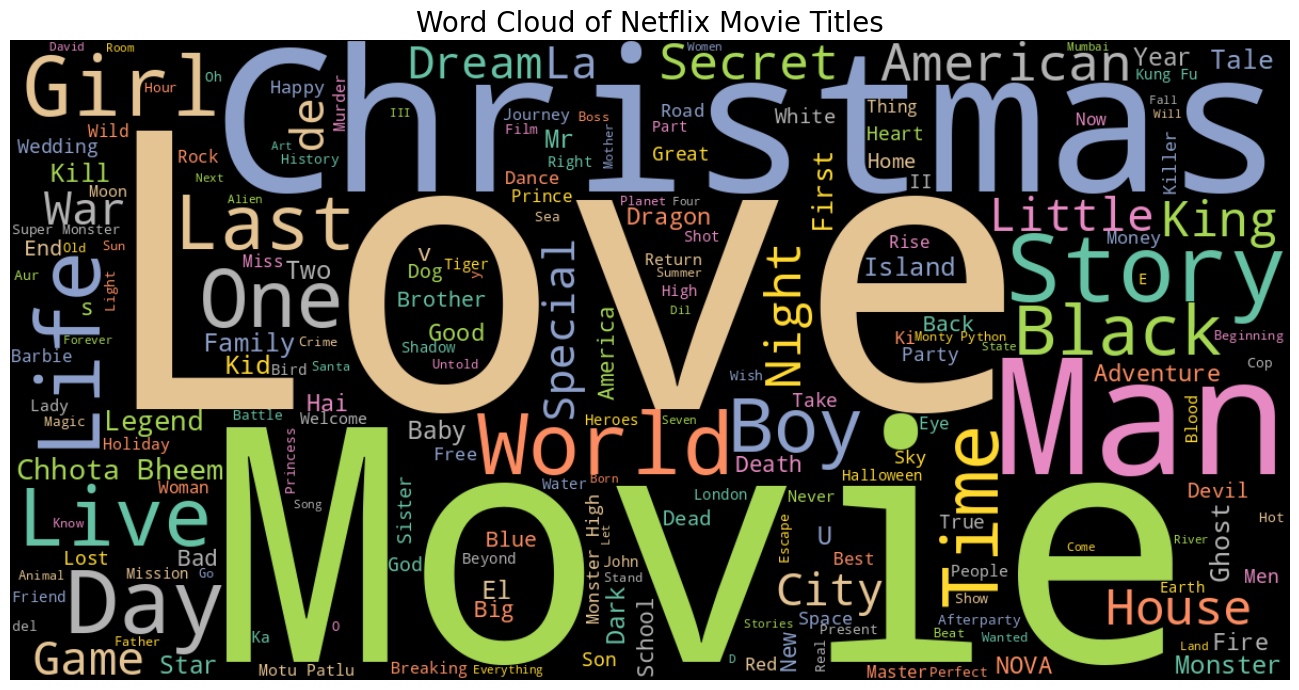

In [17]:
#  Word Cloud of Movie Titles
# We’ll generate a cloud of the most frequent words used in Netflix movie titles.

from wordcloud import WordCloud

# Filter only movie titles
movie_titles = df[df['type'] == 'Movie']['title']

# Join all titles into one string
text = ' '.join(movie_titles)

# Generate the word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='black', colormap='Set2').generate(text)

# Plot it
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Netflix Movie Titles', fontsize=20)
plt.tight_layout()
plt.show()


###☁️ Word Cloud Analysis: Netflix Movie Titles
###🔍 Top Words in Titles:
* “Movie” — Expected, since it’s from the movie subset.

* "Love", "Man", "Christmas", "War", "Life", "Story", "World", "Girl", "Boy", "Monster"
These dominate the screen — which tells us a lot about trending themes.

###💡 Key Insights:
* 🔥 Emotional Hooks are Popular
Words like "Love", "Life", "Heart", "Story", and "Dream" suggest:

* Netflix often features emotionally driven or inspirational content — romance, personal growth, drama.

###🎅 Holiday Themes Sell
* "Christmas" is one of the biggest words — meaning:

* Holiday movies are a huge seasonal category, and Netflix likely adds a lot of festive films.

###💥 Action & Adventure is Big
* Words like "War", "Kill", "Monster", "Ghost", "King", and "Dragon" suggest:

* Netflix leans into fantasy, thrillers, and action — likely because they attract binge-watching audiences.

###👨‍👩‍👧‍👦 Relatable Roles Appear Often
* Words like "Man", "Girl", "Boy", "Family", "School", "Home", "Game" — indicate:

* Many titles are built around everyday relationships or identity themes.

# Feature Engineering

In [18]:
#  Create duration_int and duration_type

# Split duration into number and unit
df[['duration_int', 'duration_type']] = df['duration'].str.extract('(\d+)\s*(\D+)')

# Convert to numeric
df['duration_int'] = pd.to_numeric(df['duration_int'])

# Preview
df[['type', 'duration', 'duration_int', 'duration_type']].head()

,type,duration,duration_int,duration_type
0,Movie,90 min,90,min
1,TV Show,1 Season,1,Season
2,TV Show,1 Season,1,Season
3,Movie,91 min,91,min
4,Movie,125 min,125,min


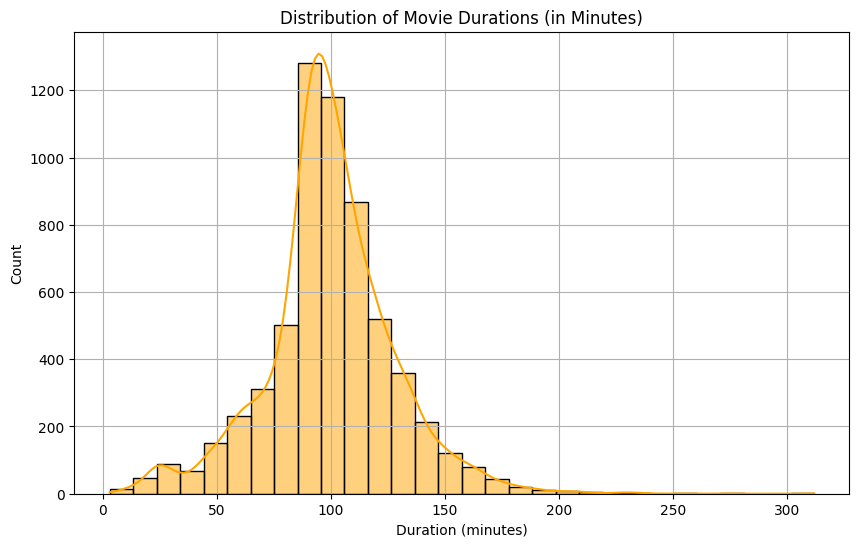

In [19]:
# Plot Duration Distribution (Movies)

# Filter movies
movie_durations = df[df['type'] == 'Movie']

plt.figure(figsize=(10, 6))
sns.histplot(data=movie_durations, x='duration_int', bins=30, color='orange', kde=True)
plt.title('Distribution of Movie Durations (in Minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

##📊 Key Insights: Distribution of Movie Durations
###Peak Duration Range:

* Most movies are between 85–100 minutes, which is the typical duration for mainstream cinema.

* This peak is clearly seen as the tallest bar in the histogram.

###Right-Skewed Distribution:

* The orange curve (KDE) shows that the data is right-skewed, meaning:

* A small number of movies have very long durations (2.5+ hours).

* These outliers are pulling the distribution's tail to the right.

###Short Movies Exist, but Are Rare:

* Some titles are under 30 minutes, but they are quite rare.

* These might be animated shorts, documentaries, or special content.

###Very Long Movies Are Uncommon:

* Only a few movies go beyond 150 minutes (2.5 hours), so users generally prefer more concise films.



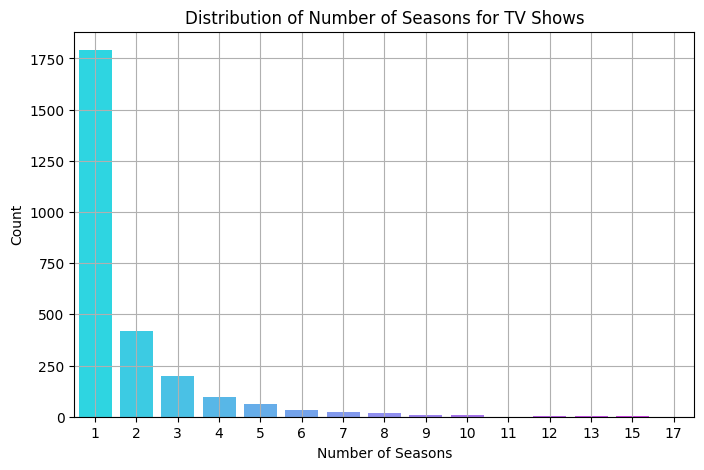

In [20]:
# Plot TV Show Seasons

tv_shows = df[df['type'] == 'TV Show']

plt.figure(figsize=(8, 5))
sns.countplot(data=tv_shows, x='duration_int', palette='cool')
plt.title('Distribution of Number of Seasons for TV Shows')
plt.xlabel('Number of Seasons')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [21]:
# ------------------ 1. Duration Features ------------------
df['duration_int'] = df['duration'].str.extract('(\d+)').astype(float)
df['duration_type'] = df['duration'].str.extract('([a-zA-Z]+)').astype(str)

# ------------------ 2. Primary Country ------------------
df['primary_country'] = df['country'].str.split(',').str[0].str.strip()

# ------------------ 3. Genre One-Hot Encoding ------------------
df['genre_list'] = df['listed_in'].str.split(', ')
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_)
df = pd.concat([df, genre_dummies], axis=1)

# ------------------ 4. Is Netflix Original ------------------
df['is_netflix_original'] = df['title'].str.contains('Netflix', case=False, na=False).astype(int)

# ------------------ 5. Duration Category ------------------
df['duration_category'] = pd.cut(df['duration_int'],
                                 bins=[0, 60, 120, 300],
                                 labels=['Short', 'Medium', 'Long'])

# ------------------ 6. Title Word Count ------------------
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))

# ------------------ 7. Thematic Flags (Christmas, Love) ------------------
df['title_lower'] = df['title'].str.lower()
df['is_christmas'] = df['title_lower'].str.contains('christmas').astype(int)
df['is_love'] = df['title_lower'].str.contains('love').astype(int)

# ------------------ 8. Release Decade ------------------
df['release_decade'] = (df['release_year'] // 10 * 10).astype(str) + 's'

# ------------------ 9. Is Movie (Binary Target) ------------------
df['is_movie'] = df['type'].apply(lambda x: 1 if x == 'Movie' else 0)

# ------------------ 10. Clean-Up Temporary Columns ------------------
df.drop(['title_lower', 'genre_list'], axis=1, inplace=True)


In [22]:
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,year_added,month_added,day_added,genres,duration_int,duration_type,primary_country,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,Documentaries,Docuseries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,International TV Shows,Kids' TV,Korean TV Shows,LGBTQ Movies,Movies,Music & Musicals,Reality TV,Romantic Movies,Romantic TV Shows,Sci-Fi & Fantasy,Science & Nature TV,Spanish-Language TV Shows,Sports Movies,Stand-Up Comedy,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers,is_netflix_original,duration_category,title_word_count,is_christmas,is_love,release_decade,is_movie
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,2021,9,25,[Documentaries],90.0,min,United States,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Medium,4,0,0,2020s,1
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",2021,9,24,"[Crime TV Shows, International TV Shows, TV Ac...",1.0,Season,France,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Short,1,0,0,2020s,0
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",2021,9,24,"[TV Dramas, TV Horror, TV Mysteries]",1.0,Season,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,Short,2,0,0,2020s,0
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",2021,9,22,"[Children & Family Movies, Comedies]",91.0,min,Brazil,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Medium,5,0,0,2020s,1
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",2021,9,24,"[Dramas, Independent Movies, International Mov...",125.0,min,United States,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Long,1,0,0,1990s,1


# Model Building

In [23]:
# Define target
target = 'is_movie'  # 1 = Movie, 0 = TV Show

# Select useful features
features = [
    'duration_int', 'title_word_count', 'is_christmas', 'is_love',
    'release_year', 'rating', 'primary_country',
    'Documentaries', 'Dramas', 'International Movies', 'Comedies'  # top genres (adjust if needed)
]

# Drop rows with missing values in these features
df_model = df[features + [target]].dropna()

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_model, columns=['rating', 'primary_country'], drop_first=True)


In [24]:
# Train-Test Split

from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=[target])
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [26]:
y_pred = model.predict(X_test)

print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy Score: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       533
           1       1.00      1.00      1.00      1225

    accuracy                           1.00      1758
   macro avg       1.00      1.00      1.00      1758
weighted avg       1.00      1.00      1.00      1758


🧩 Confusion Matrix:
 [[ 533    0]
 [   0 1225]]


In [27]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# # Build and train model
# log_model = LogisticRegression(max_iter=1000)
# log_model.fit(X_train, y_train)

# # Predict
# y_pred_log = log_model.predict(X_test)

# # Evaluate
# print("✅ Accuracy:", accuracy_score(y_test, y_pred_log))
# print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_log))
# print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
